In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition, preprocessing, cluster
import openpyxl
import os
import re
import warnings
import datetime
import scanpy as sc

import gspread
from google.oauth2.service_account import Credentials

/opt/miniconda3/envs/simbryo/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/simbryo/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/simbryo/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/simbryo/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/simbryo/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` i

In [51]:
def scatter_text(x, y, text_column, data, hue = 0):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    if hue == 0:
        p1 = sns.scatterplot(x = x,y =  y, data=data, s = 100, legend=False)
    else:
        p1 = sns.scatterplot(x = x,y =  y, data=data, hue = hue, s = 100, legend=False)

    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', size=8, color='black')

In [9]:
rnaseq_tab = pd.read_csv('/Users/aw21/Dropbox/RNASeq/ZhuRNASeqExpressionMat.csv')

### Deal with any duplicate ENS ids and gene names, get purely numeric data with gene name as index. 


In [10]:
#this checks for duplicated ENS IDs, 0 means there are none. 
rnaseq_tab.duplicated(subset = "Unnamed: 0").sum()

0

In [12]:
rnaseq_tab

,Unnamed: 0,symbol,counts..Ctrl,counts.DE.a...24hr.,counts.APS..24hr.,counts.MPS..24hr.,counts.PPS..24hr.,counts.DE.a..DE.b...48hr.,counts.APS.DE.b...48hr.,counts.MPS.DE.b...48hr.,counts.PPS.DE.b...48hr.,counts.DE.a..PM..48hr.,counts.APS.PM..48hr.,counts.MPS.PM..48hr.,counts.PPS.PM..48hr.,counts.DE.a..LM..48hr.,counts.APS.LM..48hr.,counts.MPS.LM..48hr.,counts.PPS.LM..48hr.
0,ENSG00000000003,TSPAN6,1979.681,1442.785,1634.224,2046.780,1813.428,1368.334,1152.113,1022.220,1818.867,2088.277,2269.799,1714.153,2572.260,1212.296,1066.894,1247.361,1721.116
1,ENSG00000000005,TNMD,47.718,29.000,27.000,16.001,46.001,4.000,3.000,1.000,11.000,2.000,4.000,6.000,252.017,8.000,3.000,2.000,5.000
2,ENSG00000000419,DPM1,1033.477,930.758,1368.331,1289.742,962.503,943.310,914.691,856.873,1049.629,1366.902,1201.344,909.471,1156.992,847.224,997.829,835.492,813.287
3,ENSG00000000457,SCYL3,160.849,132.058,153.138,249.167,226.102,207.627,163.048,158.758,213.208,207.972,199.929,220.455,321.312,206.366,481.480,340.931,313.558
4,ENSG00000000460,C1orf112,654.536,526.711,628.172,715.183,741.478,459.421,508.828,449.099,680.553,695.748,688.493,543.188,761.357,459.604,542.832,463.537,649.608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37946,ENSG00000287988,FO082814.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000
37947,ENSG00000288000,AL031681.2,0.000,0.000,14.090,0.000,0.000,0.000,0.000,0.000,19.570,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
37948,ENSG00000288014,AL121969.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
37949,ENSG00000288031,AC093838.2,10.000,7.000,7.000,5.000,8.000,11.000,1.000,1.000,7.000,5.000,4.000,9.000,19.000,4.000,10.000,1.000,11.004


In [13]:
#make the gene symbol the index, drop non-numeric columns
symbolCol = "symbol"
rnaseq_tab.index = rnaseq_tab[symbolCol]
rnaseq_tab.drop(columns=["Unnamed: 0",symbolCol],inplace = True)

In [14]:
#check for non-unique gene names
rnaseq_tab.index.duplicated().sum()

2011

In [15]:
#This sums expression of genes with the same name (index is gene name). 
rnaseq_tab = rnaseq_tab.groupby(rnaseq_tab.index).sum()

In [16]:
#check again:
print(rnaseq_tab.index.duplicated().sum())

0


In [17]:
rnaseq_tab

,counts..Ctrl,counts.DE.a...24hr.,counts.APS..24hr.,counts.MPS..24hr.,counts.PPS..24hr.,counts.DE.a..DE.b...48hr.,counts.APS.DE.b...48hr.,counts.MPS.DE.b...48hr.,counts.PPS.DE.b...48hr.,counts.DE.a..PM..48hr.,counts.APS.PM..48hr.,counts.MPS.PM..48hr.,counts.PPS.PM..48hr.,counts.DE.a..LM..48hr.,counts.APS.LM..48hr.,counts.MPS.LM..48hr.,counts.PPS.LM..48hr.
symbol,,,,,,,,,,,,,,,,,
A1BG,84.458,65.375,50.226,62.308,36.000,94.029,103.148,82.434,47.531,98.180,128.976,63.054,72.017,74.061,113.268,86.792,93.109
A1CF,3.000,0.000,0.000,2.000,2.034,1.000,0.000,1.000,2.000,2.000,1.000,4.000,1.000,8.000,13.074,2.000,1.000
A2M,1.000,3.000,2.000,0.000,3.000,2.000,0.000,0.000,0.000,0.000,1.000,0.000,11.024,2.000,1.000,1.000,0.000
A2ML1,155.160,27.000,29.000,12.000,44.007,157.790,150.874,66.108,41.000,37.075,14.999,7.000,15.001,33.003,5.000,9.000,60.029
A2MP1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11AP1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ZYG11B,1002.675,653.040,903.501,1128.241,1183.640,1008.769,1095.508,1072.009,1447.654,1247.754,1328.121,1130.923,1448.092,726.591,934.918,990.226,1169.686
ZYX,6050.345,8722.411,8326.391,9988.310,5955.271,2968.701,2831.658,2500.739,4875.603,4665.700,4166.075,2791.428,4314.385,2116.428,2581.626,3239.757,2673.774


### Normalization and filtering

In [18]:
# Normalize by sample counts
rnaseq_tab = rnaseq_tab/rnaseq_tab.sum(axis = 0)*1e6 # put in reads/million

In [19]:
#only keep genes with max counts > 10
rnaseq_tab = rnaseq_tab[(rnaseq_tab.max(axis = 1) > 10)]

In [20]:
#see how many genes are left
rnaseq_tab.shape

(12113, 17)

### PCA 

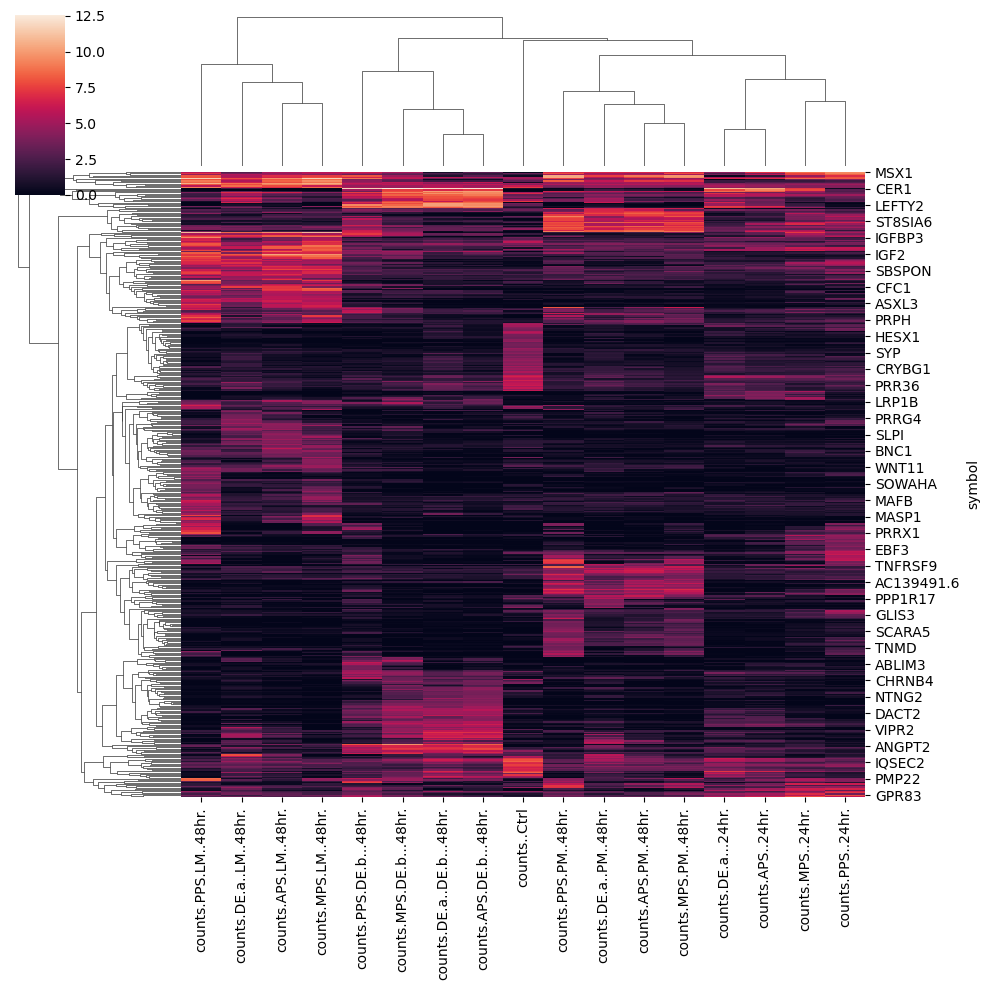

In [66]:
#look at a hierchical clustering of the data keeping only highly variable genes. Use a cutoff in coefficient of variation. 
highlyvar = rnaseq_tab[(rnaseq_tab.std(axis = 1)/rnaseq_tab.mean(axis =1) > 1.5)] 
f = sns.clustermap(np.log2(highlyvar+1))
f.savefig('clustermap.jpg')

In [68]:
f.savefig(fname = '/Users/aw21/Github/2025ZhuRNASeq/clustermap.jpg')

In [53]:
#apply standard scaling (z-scores) to the data
scaler = preprocessing.StandardScaler()
scaler.fit(rnaseq_tab.transpose())
data_scaled = scaler.transform(rnaseq_tab.transpose()) #get the scaled data

pca = decomposition.PCA()
transformed_data = pca.fit_transform(data_scaled)

pc_labels = []
for ii in range(1,rnaseq_tab.shape[1]+1):
    pc_labels.append('PC' + str(ii))
    
transformed_data = pd.DataFrame(transformed_data,columns=pc_labels,index=rnaseq_tab.columns)
transformed_data["samples"] = rnaseq_tab.columns

In [65]:
f

/var/folders/rk/4bkd164n7gz1hxs5bx0cnnpm0000gn/T/ipykernel_31247/718972848.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p1.text(data[x][line]+0.01, data[y][line],
/var/folders/rk/4bkd164n7gz1hxs5bx0cnnpm0000gn/T/ipykernel_31247/718972848.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[text_column][line], horizontalalignment='left', size=8, color='black')


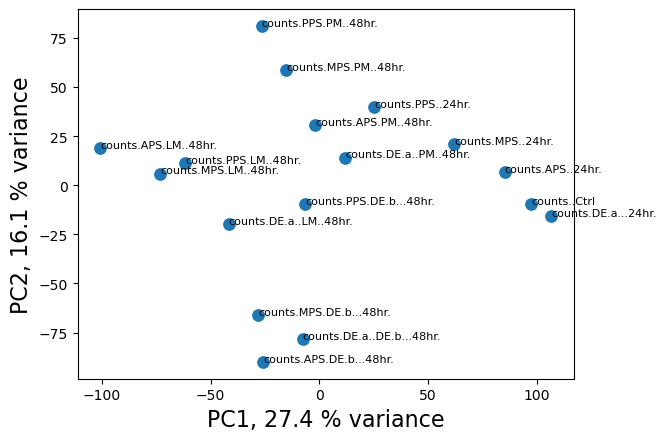

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot()
scatter_text(x = 'PC1', y = 'PC2', data=transformed_data,text_column="samples")
ax1.set_xlabel('PC1, %.1f %% variance'%(pca.explained_variance_ratio_[0]*100),fontsize=16)
ax1.set_ylabel('PC2, %.1f %% variance'%(pca.explained_variance_ratio_[1]*100),fontsize=16);

In [56]:
#apply standard scaling (z-scores) to the data
scaler = preprocessing.StandardScaler()
scaler.fit(highlyvar.transpose())
data_scaled = scaler.transform(highlyvar.transpose()) #get the scaled data

pca = decomposition.PCA()
transformed_data = pca.fit_transform(data_scaled)

pc_labels = []
for ii in range(1,highlyvar.shape[1]+1):
    pc_labels.append('PC' + str(ii))
    
transformed_data = pd.DataFrame(transformed_data,columns=pc_labels,index=rnaseq_tab.columns)
transformed_data["samples"] = rnaseq_tab.columns

/var/folders/rk/4bkd164n7gz1hxs5bx0cnnpm0000gn/T/ipykernel_31247/718972848.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p1.text(data[x][line]+0.01, data[y][line],
/var/folders/rk/4bkd164n7gz1hxs5bx0cnnpm0000gn/T/ipykernel_31247/718972848.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data[text_column][line], horizontalalignment='left', size=8, color='black')


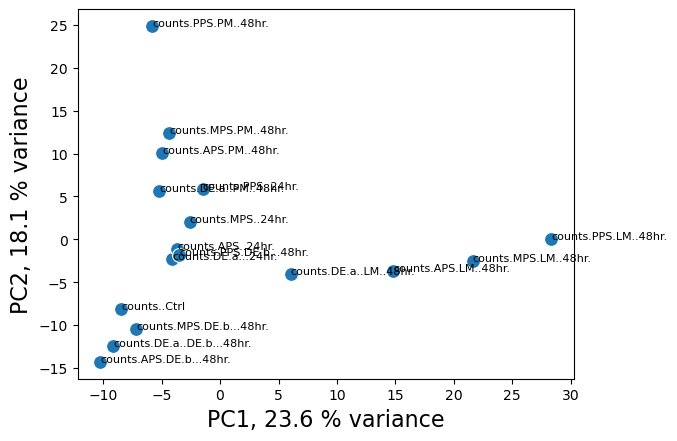

In [57]:
fig = plt.figure()
ax1 = fig.add_subplot()
scatter_text(x = 'PC1', y = 'PC2', data=transformed_data,text_column="samples")
ax1.set_xlabel('PC1, %.1f %% variance'%(pca.explained_variance_ratio_[0]*100),fontsize=16)
ax1.set_ylabel('PC2, %.1f %% variance'%(pca.explained_variance_ratio_[1]*100),fontsize=16);

#### 5 biopsies are different. These are apparently freeze thaw samples. Blood samples also don't fit, remove for now. 


In [17]:
toRemove = (transformed_data["PC2"] < -90) | (sampleTable["origin"] == "M")

In [18]:
rnaseq_tab.loc[:,toRemove].columns

Index(['S_2023_001_B', 'M_002_D', 'M_002_E', 'S_005_B', 'M_003_B', 'M_005_B',
       'M_006_B', 'S_001_B', 'S_002_B', 'S_003_B', 'S_006_B', 'S_071_B'],
      dtype='object')

In [19]:
rnaseq_tab = rnaseq_tab.loc[:,~toRemove]
sampleTable = sampleTable[~toRemove]

In [20]:
#apply standard scaling (z-scores) to the data
scaler = preprocessing.StandardScaler()
scaler.fit(rnaseq_tab.transpose())
data_scaled = scaler.transform(rnaseq_tab.transpose()) #get the scaled data

pca = decomposition.PCA()
transformed_data = pca.fit_transform(data_scaled)

pc_labels = []
for ii in range(1,rnaseq_tab.shape[1]+1):
    pc_labels.append('PC' + str(ii))
    
transformed_data = pd.DataFrame(transformed_data,columns=pc_labels,index=rnaseq_tab.columns)

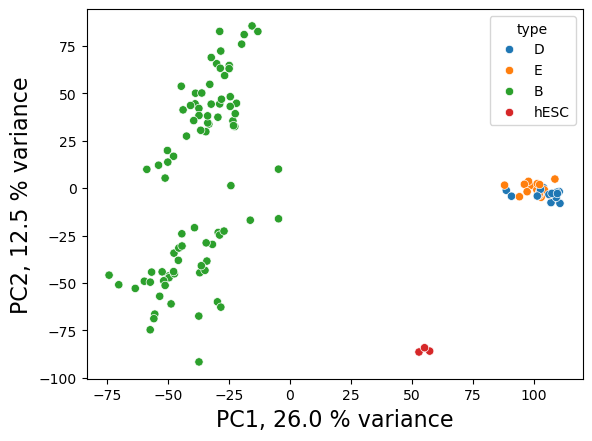

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot()
sns.scatterplot(x = 'PC1', y = 'PC2', data=transformed_data, hue=sampleTable["type"])
ax1.set_xlabel('PC1, %.1f %% variance'%(pca.explained_variance_ratio_[0]*100),fontsize=16)
ax1.set_ylabel('PC2, %.1f %% variance'%(pca.explained_variance_ratio_[1]*100),fontsize=16);

#### restrict to biopsies only

In [22]:
biopsies = rnaseq_tab.loc[:,sampleTable["type"]=="B"].copy()


#apply standard scaling (z-scores) to the data
scaler = preprocessing.StandardScaler()
scaler.fit(rnaseq_tab.transpose())
data_scaled = scaler.transform(biopsies.transpose()) #get the scaled data

pca = decomposition.PCA()
transformed_data = pca.fit_transform(data_scaled)

pc_labels = []
for ii in range(1,biopsies.shape[1]+1):
    pc_labels.append('PC' + str(ii))
    
transformed_data = pd.DataFrame(transformed_data,columns=pc_labels)
transformed_data["sample_labels"] = sampleTable[sampleTable["type"]=="B"].index

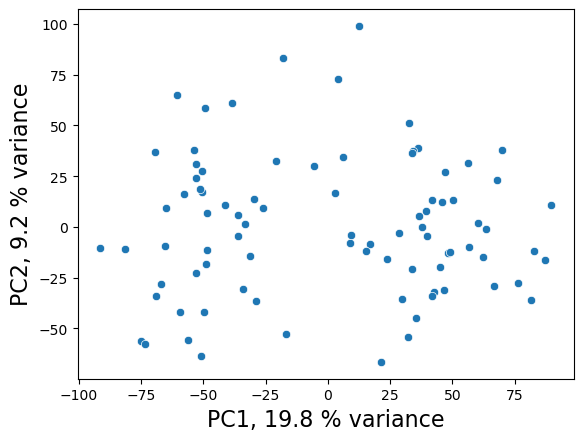

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot()
sns.scatterplot(x = 'PC1', y = 'PC2', data=transformed_data, ax = ax1)
ax1.set_xlabel('PC1, %.1f %% variance'%(pca.explained_variance_ratio_[0]*100),fontsize=16)
ax1.set_ylabel('PC2, %.1f %% variance'%(pca.explained_variance_ratio_[1]*100),fontsize=16);

/opt/miniconda3/envs/simbryo/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/miniconda3/envs/simbryo/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


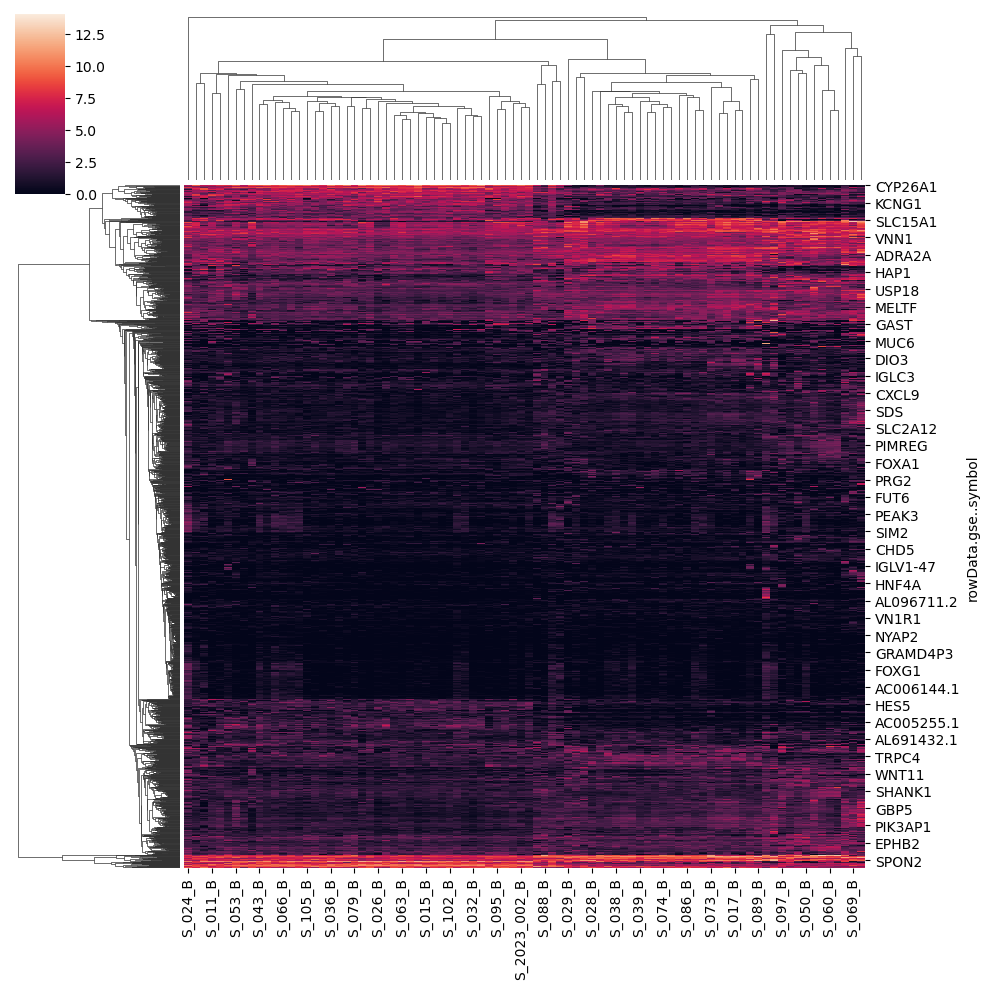

In [24]:
#look at a hierchical clustering of the data keeping only highly variable genes. Use a cutoff in coefficient of variation. 
highlyvar = biopsies[(biopsies.std(axis = 1)/biopsies.mean(axis =1) > 1)] 
sns.clustermap(np.log2(highlyvar+1));

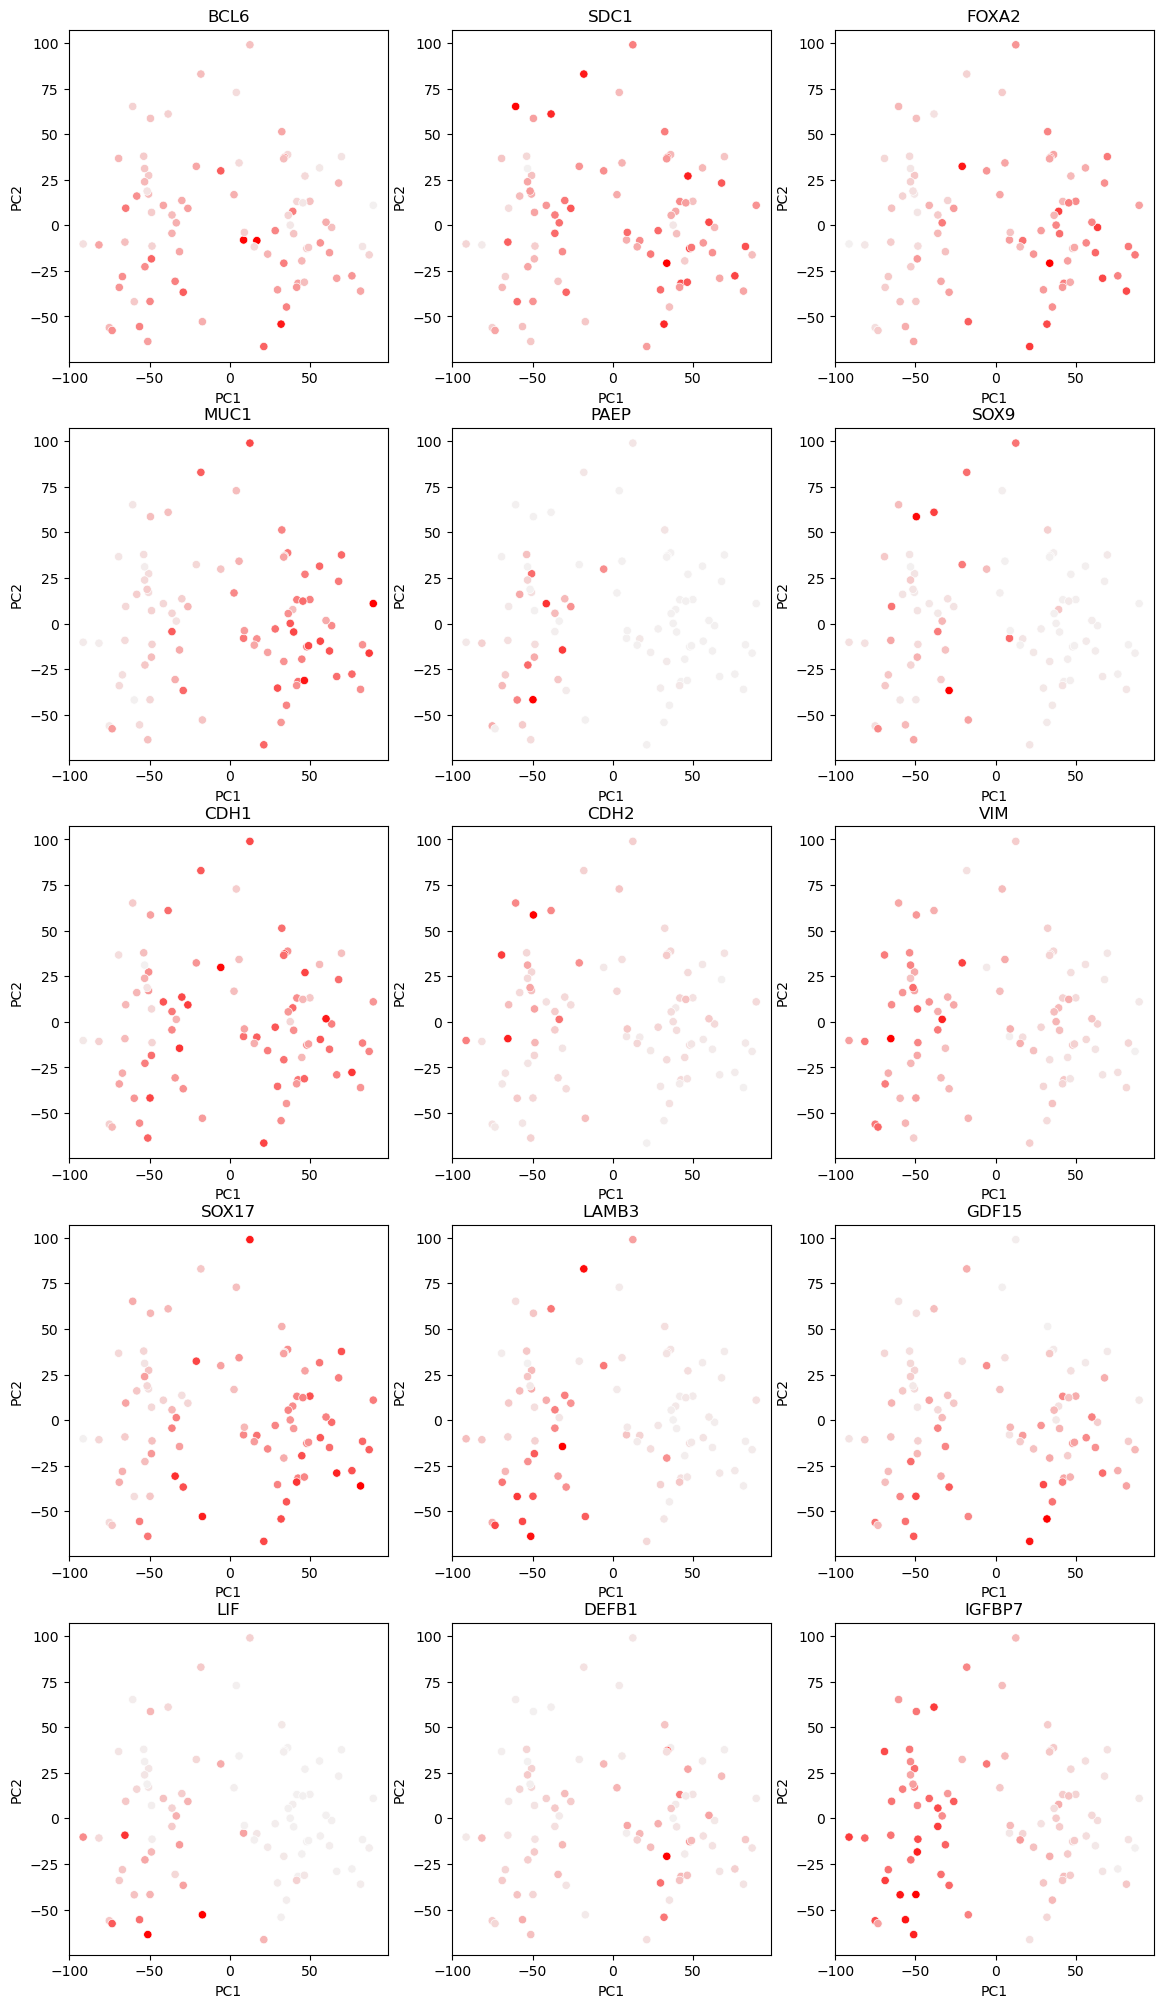

In [25]:
genelist = ['BCL6','SDC1','FOXA2','MUC1','PAEP','SOX9','CDH1','CDH2','VIM',"SOX17","LAMB3","GDF15","LIF","DEFB1","IGFBP7"]
fig, axs = plt.subplots(5,3,figsize = (14,25))
#pal = sns.cubehelix_palette(light = 0.8, dark = 0.2, rot = -0.75, as_cmap=True)
#pal = sns.color_palette("Spectral", as_cmap=True)
pal = sns.light_palette("red",as_cmap=True)
for ii in range(len(genelist)):
    genevals = biopsies.loc[genelist[ii]].to_numpy()
    
    norm = plt.Normalize(genevals.min(),genevals.max())
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)

    row = np.floor(ii/3)
    row = row.astype(np.int16)
    col = ii-row*3
    col = col.astype(np.int16)
    sns.scatterplot(x = 'PC1',y = 'PC2', data=transformed_data, hue = genevals, ax = axs[row,col],palette=pal,legend=False)
    axs[row,col].set_title(genelist[ii])
    #plt.colorbar()
    #axs[row,col].figure.colorbar(sm,ax = axs[row,col])

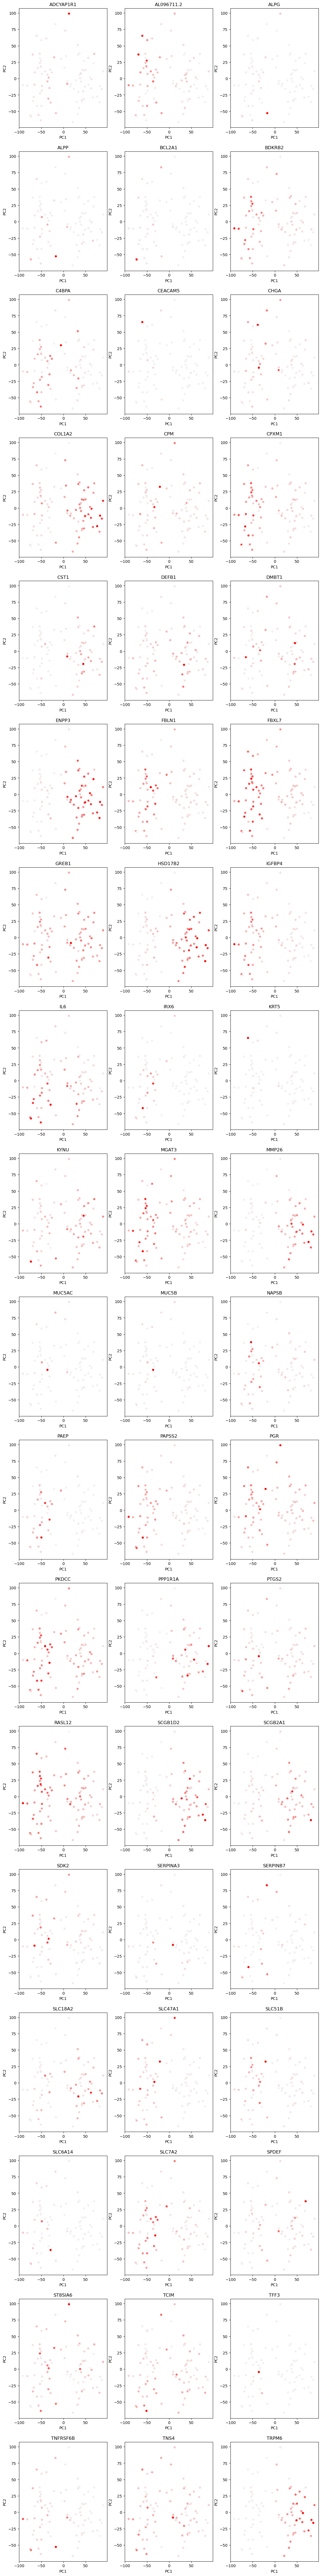

In [26]:
genelist = np.load('progRespGenes.npy',allow_pickle=True)
#genelist = ['BCL6','SDC1','FOXA2','MUC1','PAEP','SOX9','CDH1','CDH2','VIM',"SOX17","LAMB3","GDF15","LIF","DEFB1","IGFBP7"]
fig, axs = plt.subplots(18,3,figsize = (14,120))
#pal = sns.cubehelix_palette(light = 0.8, dark = 0.2, rot = -0.75, as_cmap=True)
#pal = sns.color_palette("Spectral", as_cmap=True)
pal = sns.light_palette("red",as_cmap=True)
for ii in range(len(genelist)):
    genevals = biopsies.loc[genelist[ii]].to_numpy()
    
    norm = plt.Normalize(genevals.min(),genevals.max())
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)

    row = np.floor(ii/3)
    row = row.astype(np.int16)
    col = ii-row*3
    col = col.astype(np.int16)
    sns.scatterplot(x = 'PC1',y = 'PC2', data=transformed_data, hue = genevals, ax = axs[row,col],palette=pal,legend=False)
    axs[row,col].set_title(genelist[ii])
    #plt.colorbar()
    #axs[row,col].figure.colorbar(sm,ax = axs[row,col])

### Analysis of some individual genes

In [24]:
def geneExpressionByName(bdata,regEx):
    """Function to return table of gene expression based on regex matching"""
    r = re.compile(regEx)
    namesToUse = list(filter(r.match,bdata.index))
    return bdata.loc[namesToUse]

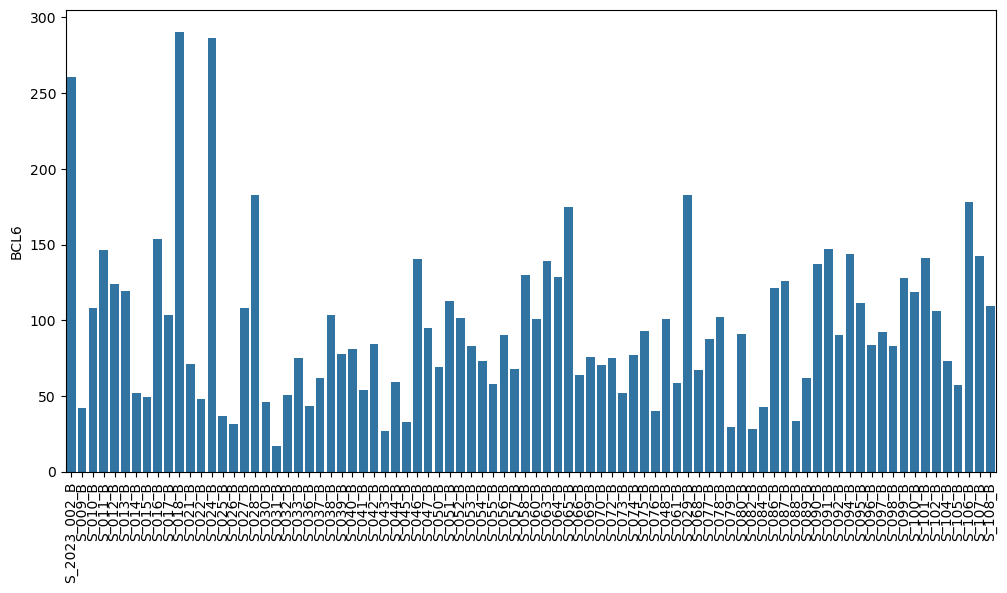

In [27]:
fig, ax1 = plt.subplots(figsize = (12,6))
ax1 = sns.barplot(biopsies.loc["BCL6"]);
ax1.tick_params(axis='x',rotation = 90)

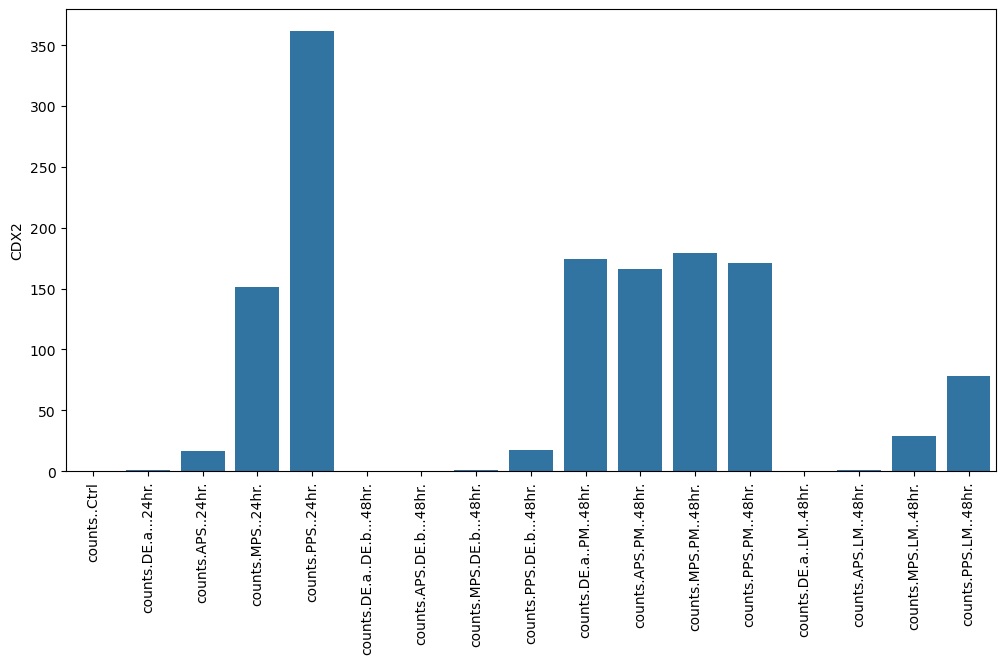

In [44]:
fig, ax1 = plt.subplots(figsize = (12,6))
ax1 = sns.barplot(rnaseq_tab.loc["CDX2"]);
ax1.tick_params(axis='x',rotation = 90)

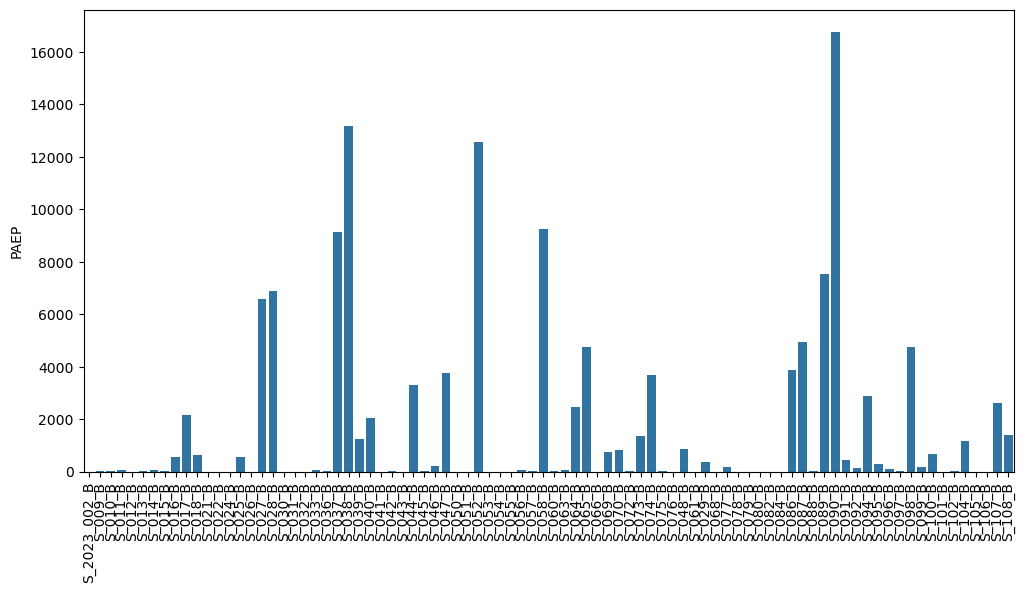

In [29]:
fig, ax1 = plt.subplots(figsize = (12,6))
ax1 = sns.barplot(biopsies.loc["PAEP"]);
ax1.tick_params(axis='x',rotation = 90)

In [30]:
#Read ET patient sample database:
#psDB = pd.read_excel('/Users/aw21/Downloads/PatientSampleDatabase.xlsx')

In [31]:
#restrict sample table to biopsy samples:
sampleTable_biopsy = sampleTable.loc[sampleTable["type"]=="B"].copy()
#sampleTable_biopsy

In [32]:
sampleIDs = psDB["InternalID"].str.replace('SIM','S').str.replace('-','_') #make sample ids match
psDB.index = [x+'_B' for x in sampleIDs] #set index so it is the same as sampleTable

#sampleIDs

In [33]:
# import data from psDB to sampleTable_biopsy
sampleTable_biopsy.loc[:,"Participant ID"] = psDB.loc[:,"Participant ID"].copy()
sampleTable_biopsy.loc[:,"Clinic_Outcome"]=psDB.loc[:,"Transfer_outcome"].copy()
sampleTable_biopsy.loc[:,"Initials"]=psDB.loc[:,"Biopsy_initial_internal"].copy()
sampleTable_biopsy.loc[:,"Receptiva_diagnosis"]=psDB.loc[:,"Receptiva_diagnosis"]
sampleTable_biopsy.loc[:,"Receptiva_BCL6"]=psDB.loc[:,"Receptiva_BCL6"]
sampleTable_biopsy.loc[:,"Clinic"]=psDB.loc[:,"Location"]
sampleTable_biopsy.loc[:,"ERA_result"]=(psDB["Igenomix_ERA_results"]+psDB["ERPeak_result"])
sampleTable_biopsy.replace("",np.nan,inplace=True)

/var/folders/rk/4bkd164n7gz1hxs5bx0cnnpm0000gn/T/ipykernel_63930/2757674524.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sampleTable_biopsy.replace("",np.nan,inplace=True)


In [36]:
biopsies.drop(["S_2023_002_B"],axis = 1,inplace=True)
sampleTable_biopsy.drop(["S_2023_002_B"],axis = 0,inplace=True)

KeyError: "['S_2023_002_B'] not found in axis"

In [37]:
#apply standard scaling (z-scores) to the data
scaler = preprocessing.StandardScaler()
scaler.fit(rnaseq_tab.transpose())
data_scaled = scaler.transform(biopsies.transpose()) #get the scaled data

pca = decomposition.PCA()
transformed_data = pca.fit_transform(data_scaled)

pc_labels = []
for ii in range(1,biopsies.shape[1]+1):
    pc_labels.append('PC' + str(ii))
    
transformed_data = pd.DataFrame(transformed_data,columns=pc_labels)
transformed_data["sample_labels"] = sampleTable_biopsy.index

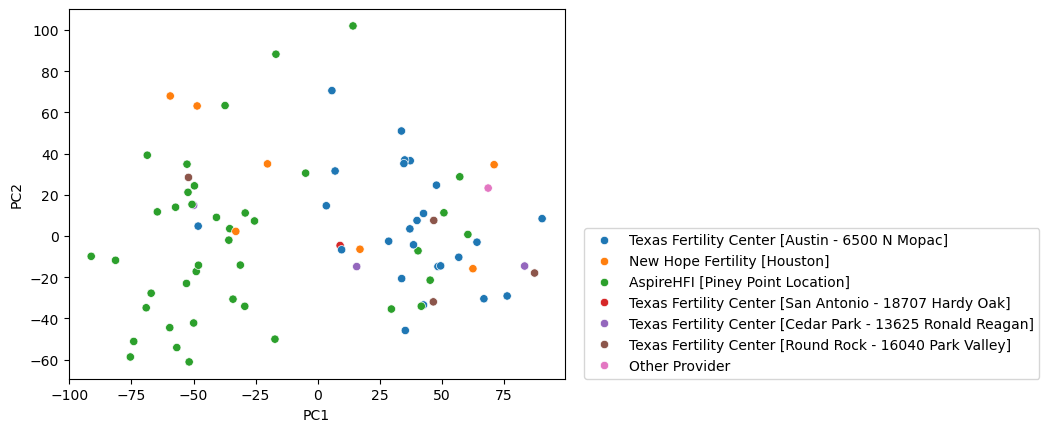

In [38]:
fig, ax1 = plt.subplots()
sns.scatterplot(x = 'PC1', y = 'PC2', data=transformed_data,hue = sampleTable_biopsy["Clinic"].to_numpy(), ax = ax1)#, size= sampleTable_biopsy["Clinic"])
fig.savefig('byClinic.jpg',bbox_inches = 'tight')
ax1.legend(loc = (1.04,0))

<Axes: xlabel='PC1', ylabel='PC2'>

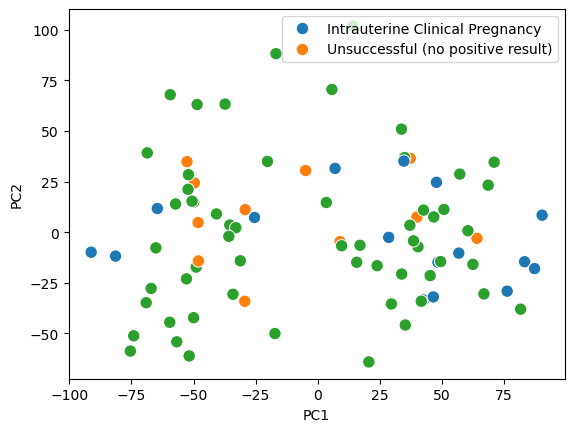

In [39]:
sns.scatterplot(x = 'PC1', y = 'PC2', data=transformed_data,hue = sampleTable_biopsy.fillna("")["Clinic_Outcome"].to_numpy(), s = 80)#, size= sampleTable_biopsy["Clinic"])

<Axes: xlabel='PC1', ylabel='PC2'>

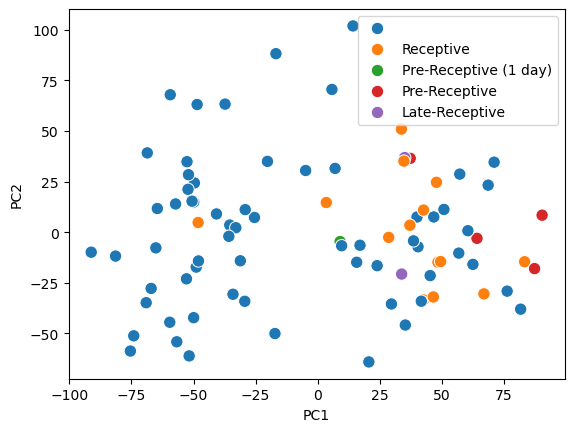

In [40]:
fig, ax1 = plt.subplots()
sns.scatterplot(x = 'PC1', y = 'PC2', data=transformed_data,hue = sampleTable_biopsy.fillna(" ")["ERA_result"].to_numpy(), s = 80, ax = ax1)#, size= sampleTable_biopsy["Clinic"])

In [41]:
sampleTable_biopsy["SampleID"] = sampleTable_biopsy.index
sampleTable_biopsy.index = sampleTable_biopsy["Participant ID"]
sampleTable_biopsy.drop("Participant ID",axis = 1, inplace = True)

In [42]:
bcl6 = rnaseq_tab.loc["BCL6"]
bclmerge = pd.merge(bcl6,sampleTable_biopsy,left_index=True, right_on = "SampleID").replace('',np.nan)

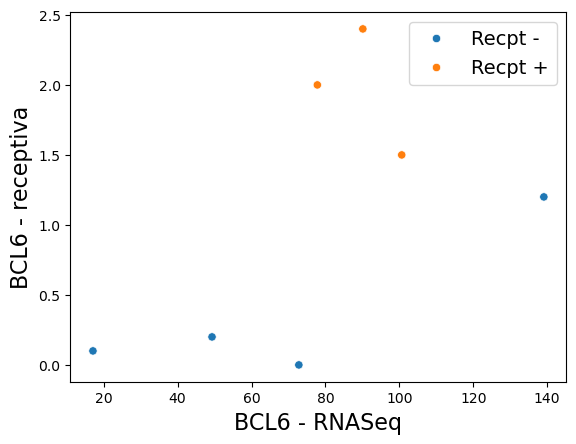

In [43]:
fig, ax1 = plt.subplots()
sns.scatterplot(data=bclmerge,x='BCL6',y='Receptiva_BCL6',hue='Receptiva_diagnosis',ax = ax1)
handles, labels  =  ax1.get_legend_handles_labels()
ax1.set_xlabel('BCL6 - RNASeq',fontsize = 16)
ax1.set_ylabel('BCL6 - receptiva',fontsize = 16);
ax1.legend(handles, ['Recpt -', 'Recpt +'], loc='upper right',fontsize = 14);
fig.savefig('rnaseq_vs_receptiva.jpg',bbox_inches = 'tight')

In [44]:
sampleTable_biopsy.loc[:,"CD138_diag"]=psDB.loc[:,"What were the CD138 Results1"]
#sampleTable_biopsy.loc[:,"BCL_level"]=psDB.loc[:,"BCL6 Expression (Number)"]
cd138 = rnaseq_tab.loc["SDC1"]
cd138merge = pd.merge(cd138,sampleTable_biopsy,left_index=True, right_on = "SampleID").replace('',np.nan)

KeyError: 'What were the CD138 Results1'

In [114]:
cd138merge.dropna(subset=["CD138_diag"])

,SDC1,origin,type,Clinic_Outcome,Initials,BCL_diag,BCL_level,Clinic,SampleID,CD138_diag
Participant ID,,,,,,,,,,


In [45]:
geneExpr_corr = rnaseq_tab.transpose().corr()

In [46]:
geneExpr_corr.loc["BCL6"].sort_values().tail(20)

rowData.gse..symbol
NR4A2       0.779917
TRIB1       0.780123
CHD1        0.783109
NFIL3       0.783752
IRS2        0.785299
NR4A1       0.785783
EIF1        0.787921
DNAJB9      0.788687
PCF11       0.789496
TOB1        0.793672
KLF6        0.794511
WEE1        0.797128
ZNF331      0.797160
FRMD4B      0.800912
SLC25A25    0.802269
RNF122      0.808666
UBC         0.824450
PIGA        0.838280
ETS2        0.864949
BCL6        1.000000
Name: BCL6, dtype: float64

In [47]:
corr_genes = ['ETS2','PIGA','WEE1','CEBPD','RNF122','KLF6']

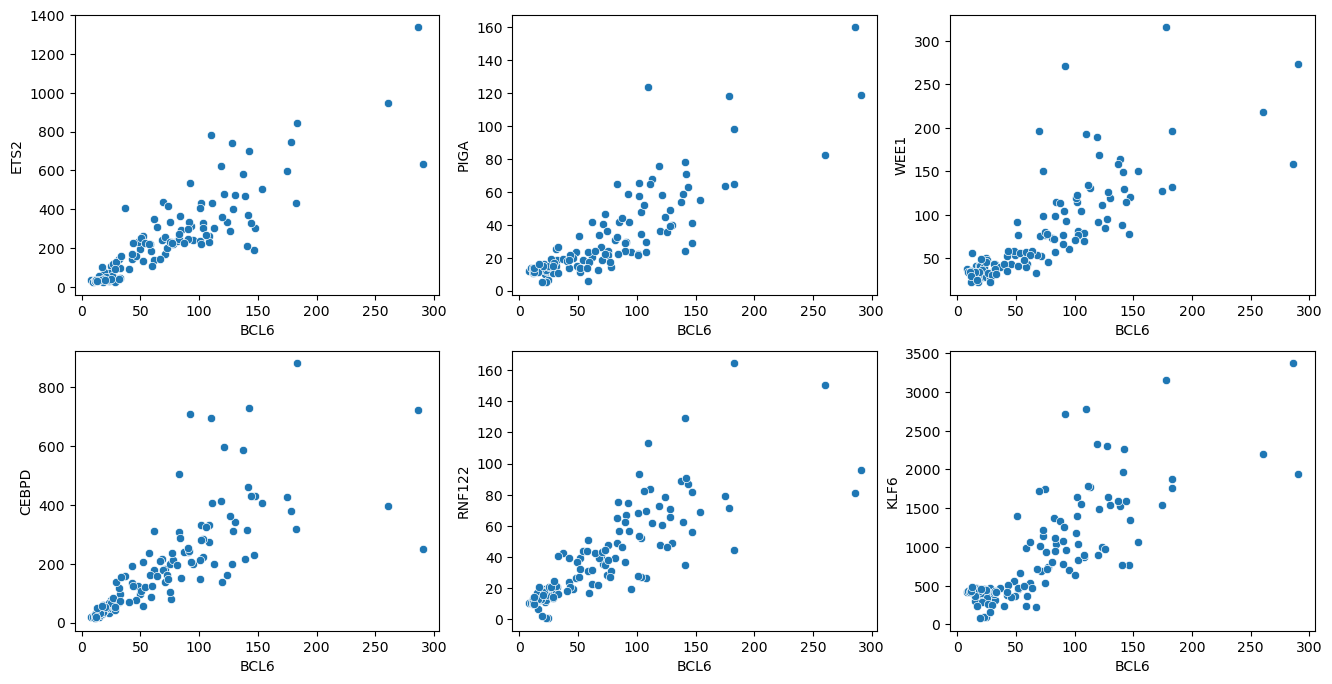

In [48]:
fig, axs = plt.subplots(2,3,figsize = (16,8))
for ii in range(6):
    rr = np.int16(np.floor(ii/3))
    cc = np.int16(ii - 3*rr)
    sns.scatterplot(data = rnaseq_tab.transpose(), x = 'BCL6', y = corr_genes[ii],ax = axs[rr,cc])
fig.savefig('GeneCorr.jpg',bbox_inches = 'tight')

In [49]:
#psDB.loc[:,psDB.columns.str.contains("ALICE")].replace('',np.nan). dropna(subset = ['ALICE: % Escherichia1'], how='all').dropna(axis = 1)

In [50]:
sampleTable_biopsy_onlyERA = sampleTable_biopsy.loc[~sampleTable_biopsy["ERA_result"].isna()]

In [51]:
biopsies_onlyERA = biopsies.loc[:,~sampleTable_biopsy["ERA_result"].isna()]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [134]:
#apply standard scaling (z-scores) to the data
scaler = preprocessing.StandardScaler()
scaler.fit(rnaseq_tab.transpose())
data_scaled = scaler.transform(biopsies_onlyERA.transpose()) #get the scaled data

pca = decomposition.PCA()
transformed_data = pca.fit_transform(data_scaled)

pc_labels = []
for ii in range(1,biopsies_onlyERA.shape[1]+1):
    pc_labels.append('PC' + str(ii))
    
transformed_data = pd.DataFrame(transformed_data,columns=pc_labels)
transformed_data["sample_labels"] = sampleTable_biopsy_onlyERA.index

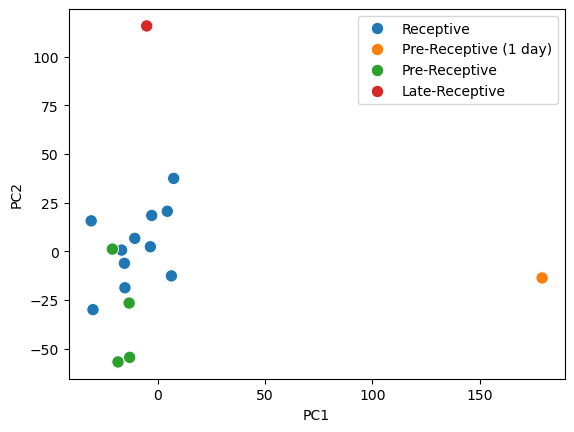

In [137]:
fig, ax1 = plt.subplots()
sns.scatterplot(x = 'PC1', y = 'PC2', data=transformed_data,hue = sampleTable_biopsy_onlyERA["ERA_result"].to_numpy(), s = 80, ax = ax1)
fig.savefig('PCA_ERAresults.jpg')

In [136]:
sampleTable_biopsy_onlyERA.shape

(17, 9)